# ちょっぴりDD事前準備

事前準備を行います。

## データ準備

とりあえず作成したbrave.csvとmonster.csvをデータ分析に使える形にする

事前にS3バケットを作成しておく必要がある。さらに、SageMakerのIAMロールに適切な権限を付与する必要がある。

In [10]:
import pandas as pd
import numpy as np

In [11]:
brave_path = './data/brave.csv'
braves = pd.read_csv(brave_path, header=0)
braves.head()

,id,name,sex,age,attack
0,1,ImamuraYoshimi,女,39,950
1,2,KanayaNene,女,46,200
2,3,SumidaRui,男,17,953
3,4,FukuzawaMiu,女,57,861
4,5,AmemiyaMitsuo,男,54,834


In [32]:
monster_path = './data/monster.csv'
monsters = pd.read_csv(monster_path, header=None)
monsters = monsters.rename(columns={0: 'name'})
monsters.head()

,name
0,スライム
1,ドラキー
2,スライムベス
3,ゴースト
4,モーモン


In [33]:
monsters['def'] = pd.Series( np.random.random( len(monsters))*100, index=monsters.index )
monsters.head()

,name,def
0,スライム,45.427266
1,ドラキー,27.042785
2,スライムベス,24.980913
3,ゴースト,11.291767
4,モーモン,26.504034


In [82]:
import random

train_output_path = './data/train.csv'

def calc_damage(bm):
    return (bm[4]/(bm[6]*bm[3]))*random.uniform(100, 120)

# 勇者からモンスターへの攻撃を想定した表を作る
## 学習用
tbl = pd.DataFrame( columns = ['braveid', 'bravename', 'bravesex', 'braveage', 'braveattack', 'monstername', 'monsterdef', 'damage'])
for i in range(10000):
    brave_rand = random.randrange(len(braves))
    monster_rand = random.randrange(len(monsters))
    bm = np.concatenate([braves.loc[brave_rand], monsters.loc[monster_rand]], 0)
    tmp = pd.Series( np.append(bm, calc_damage(bm)), index=tbl.columns )
    tbl = tbl.append( tmp, ignore_index=True)
tbl.to_csv(train_output_path)

tbl.head()

,braveid,bravename,bravesex,braveage,braveattack,monstername,monsterdef,damage
0,180,TodaAiko,女,46,372,メタスラ＆ゴールドマン,59.881199,14.455050
1,596,YanagidaHinano,女,56,159,ベリアル,20.124379,16.670061
2,7,YoshiiKiyoto,男,58,598,ほのおのせんし,10.511857,100.431079
3,633,MimuraAyana,女,36,885,スライムかがみもち,20.548310,127.841901
4,987,YanagiAzumi,女,13,210,マポレーナ,68.868410,26.438344


In [86]:
test_output_path = './data/test.csv'

# 勇者からモンスターへの攻撃を想定した表を作る
## テスト用
tbl = pd.DataFrame( columns = ['braveid', 'bravename', 'bravesex', 'braveage', 'braveattack', 'monstername', 'monsterdef'])
for i in range(2000):
    brave_rand = random.randrange(len(braves))
    monster_rand = random.randrange(len(monsters))
    bm = np.concatenate([braves.loc[brave_rand], monsters.loc[monster_rand]], 0)
    tmp = pd.Series( bm, index=tbl.columns )
    tbl = tbl.append( tmp, ignore_index=True)
tbl.to_csv(test_output_path)

tbl.head()

,braveid,bravename,bravesex,braveage,braveattack,monstername,monsterdef
0,802,OuuchiIsao,男,56,208,ゲリュオン,8.594849
1,588,KikutaRyuugo,男,56,753,タコメット,62.887950
2,976,TakazawaHitomi,女,45,166,スカラベキング,14.154066
3,56,OoiNozomi,女,44,498,碧落天バリゲーン,38.850745
4,129,HoriiTakeshi,男,56,215,グール,11.990870


In [91]:
# testデータをdynamoDBに配置する
import boto3
from boto3.session import Session

tablename = 'dddemo'

dynamodb = boto3.resource('dynamodb')

def create_table():
    table = dynamodb.create_table(
        TableName = tablename,
        KeySchema =[
            {
                'AttributeName' : 'id',
                'KeyType' : 'HASH'
            },
        ],
        AttributeDefinitions = [
            {
                'AttributeName' : 'id',
                'AttributeType' : 'S'
            },
        ],
        ProvisionedThroughput = {
            'ReadCapacityUnits' : 1,
            'WriteCapacityUnits' : 1
        }
    )
    table.meta.client.get_waiter('table_exists').wait(TableName = tablename)
    print (table.item_count)


create_table()

0


In [106]:
# dynamodb tableにデータを投入する

import json
import decimal

data = tbl.to_dict(orient='records')
table = dynamodb.Table(tablename)

with table.batch_writer() as batch:
    for idx, item in enumerate(data):
        # ここで、NaNが入っているkeyを落とします。nanのままだとエラーになります。
        item_not_has_nan = {key: item[key] for key in item if item[key] is not np.nan}
        item_decimal = json.loads(json.dumps(item_not_has_nan), parse_float=decimal.Decimal) # floatをdecimalにしないとエラー
        item_decimal['id'] = str(idx)
        #print(item_decimal)
        batch.put_item(Item=item_decimal)

In [116]:
# s3にデータを配置する

## 基礎編用、brave.csvをs3に配置する
import boto3

bucket = 'dddemo-067150986393'
input_location = './data/monster.csv'
output_location = 'data/year=2021/monster.csv'

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket)
bucket.upload_file(input_location, output_location)

SageMakerでXGBoostを使ってダメージの学習を行う。

In [117]:
# セットアップ
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker

print('Current SageMaker Python SDK Version ={0}'.format(sagemaker.__version__))

Current SageMaker Python SDK Version =2.41.0


In [119]:
damage = pd.read_csv('./data/train.csv')
damage.head()

,Unnamed: 0,braveid,bravename,bravesex,braveage,braveattack,monstername,monsterdef,damage
0,0,180,TodaAiko,女,46,372,メタスラ＆ゴールドマン,59.881199,14.455050
1,1,596,YanagidaHinano,女,56,159,ベリアル,20.124379,16.670061
2,2,7,YoshiiKiyoto,男,58,598,ほのおのせんし,10.511857,100.431079
3,3,633,MimuraAyana,女,36,885,スライムかがみもち,20.548310,127.841901
4,4,987,YanagiAzumi,女,13,210,マポレーナ,68.868410,26.438344


In [120]:
for column in damage.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=damage[column], columns='% observations', normalize='columns'))

col_0,% observations
bravename,
AbeSaika,0.0008
AbeYoshio,0.0008
AdachiKano,0.0009
AganoAsuka,0.0010
AganoShigeki,0.0005
...,...
YoshiwaraKamna,0.0013
YoshizakiReiji,0.0005
YoshizawaKen,0.0003


col_0,% observations
bravesex,
女,0.5253
男,0.4747


col_0,% observations
monstername,
あくまのきし,0.0027
あくま神官,0.0026
あばれこまいぬ,0.0020
あやしいかげ,0.0032
いたずらもぐら,0.0032
...,...
賀正大王スライム,0.0027
金のおたからミミック,0.0036
銀のおたからミミック,0.0019


,Unnamed: 0,braveid,braveage,braveattack,monsterdef,damage
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,504.408100,34.479800,502.917300,47.211425,248.694787
std,2886.89568,289.206633,14.567732,289.088105,27.950738,1966.324618
min,0.00000,1.000000,10.000000,1.000000,0.108827,0.018900
25%,2499.75000,256.750000,22.000000,252.000000,24.400475,17.432581
50%,4999.50000,507.000000,34.000000,486.000000,46.464396,36.833669
75%,7499.25000,753.000000,47.000000,757.000000,69.183814,86.958888
max,9999.00000,1000.000000,59.000000,1000.000000,99.599742,67111.394046


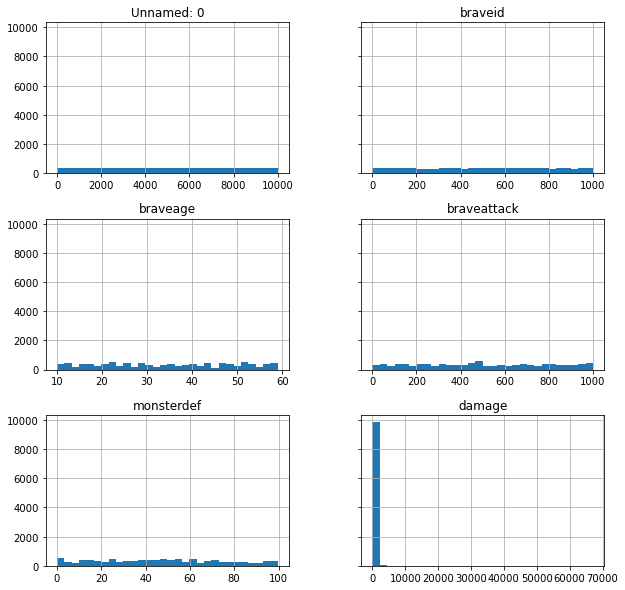

In [121]:
display(damage.describe())
%matplotlib inline
hist = damage.hist(bins=30, sharey=True, figsize=(10, 10))

In [122]:
damage = damage.drop('bravename', axis=1)
damage = damage.drop('monstername', axis=1)

In [123]:
damage

,Unnamed: 0,braveid,bravesex,braveage,braveattack,monsterdef,damage
0,0,180,女,46,372,59.881199,14.455050
1,1,596,女,56,159,20.124379,16.670061
2,2,7,男,58,598,10.511857,100.431079
3,3,633,女,36,885,20.548310,127.841901
4,4,987,女,13,210,68.868410,26.438344
...,...,...,...,...,...,...,...
9995,9995,864,女,43,87,47.881108,4.466427
9996,9996,897,女,37,265,57.066569,13.251884
9997,9997,856,男,34,268,61.505811,15.053181
9998,9998,256,男,55,345,79.139865,9.344150


In [125]:
sex_mapping = { '男':0, '女':1 }
damage['bravesex'] = damage['bravesex'].map(sex_mapping)
damage

,Unnamed: 0,braveid,bravesex,braveage,braveattack,monsterdef,damage
0,0,180,1,46,372,59.881199,14.455050
1,1,596,1,56,159,20.124379,16.670061
2,2,7,0,58,598,10.511857,100.431079
3,3,633,1,36,885,20.548310,127.841901
4,4,987,1,13,210,68.868410,26.438344
...,...,...,...,...,...,...,...
9995,9995,864,1,43,87,47.881108,4.466427
9996,9996,897,1,37,265,57.066569,13.251884
9997,9997,856,0,34,268,61.505811,15.053181
9998,9998,256,0,55,345,79.139865,9.344150


In [129]:
X = damage.iloc[:,:-1].values  # 説明変数（最後の列以外）
y = damage.iloc[:,-1].values   # 目的変数（最後の列のみ）

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25,
    random_state = 1)

In [132]:
damage.iloc[0:1]

,Unnamed: 0,braveid,bravesex,braveage,braveattack,monsterdef,damage
0,0,180,1,46,372,59.881199,14.45505


In [137]:
!{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

     |████████████████████████████████| 166.7 MB 5.5 kB/s  eta 0:00:01


In [138]:
xgb_reg = xgb.XGBRegressor()

params=[{'max_depth':[3,4,5,6],
        'n_estimators':[100,300,500]
       }]

scorer=make_scorer(mean_squared_error, False)

grid_xgb_reg=GridSearchCV(xgb_reg,
                          param_grid=params,
                          scoring=scorer,
                          cv=5,
                          n_jobs=-1)

grid_xgb_reg.fit(X_train, y_train)

y_train_pred = grid_xgb_reg.predict(X_train)
y_test_pred = grid_xgb_reg.predict(X_test)

print(grid_xgb_reg.best_params_)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass greater_is_better=False as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


{'max_depth': 3, 'n_estimators': 500}


In [ ]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('テストデータ')
plt.ylabel('予測データ')